In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [29]:
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
data = pd.read_excel('Online_Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [30]:
data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [32]:
missing_values = data.isnull().sum()
print(missing_values)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [33]:
data.dropna(subset=['CustomerID'], inplace=True)

In [34]:
data = data[(data['Quantity']>0) & (data['UnitPrice']>0)]

In [35]:
data['CustomerID'] = data['CustomerID'].astype(int)
print(data.dtypes)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
dtype: object


In [36]:
snapshot_date  = max(data['InvoiceDate']) + pd.DateOffset(days=1)
data['Total'] = data['Quantity']* data['UnitPrice']
rfm  = data.groupby('CustomerID').agg({'InvoiceDate' : lambda x : (snapshot_date - x.max()).days, 'InvoiceNo':'nunique','Total':'sum'})

In [38]:
rfm.rename(columns={'InvoiceDate' : 'Recency', 'InvoiceNo' : 'Frequency', 'Total' : 'MonetaryValue'}, inplace=True)
rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


In [39]:
rfm.describe()

,Recency,Frequency,MonetaryValue
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266460
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


In [40]:
recency_bin = [rfm['Recency'].min()-1, 20, 50, 150, 250, rfm['Recency'].max()]
frequency_bin = [rfm['Frequency'].min()-1, 2,3,10,100, rfm['Frequency'].max()]
monetary_bin = [rfm['MonetaryValue'].min()-3,300, 600, 2000, 5000,rfm['MonetaryValue'].max()]

In [47]:
rfm['R'] = pd.cut(rfm['Recency'],bins = recency_bin, labels = range(1,6), include_lowest=True)
rfm['R'] = 6 - rfm['R'].astype(int)
rfm['F'] = pd.cut(rfm['Frequency'], bins=frequency_bin, labels=range(1, 6), include_lowest=True).astype(int)
rfm['M'] = pd.cut(rfm['MonetaryValue'], bins=monetary_bin, labels=range(1, 6), include_lowest=True).astype(int)

In [48]:
print(rfm[['R','F','M']].head(10))

            R  F  M
CustomerID         
12346       1  1  5
12347       5  3  4
12348       3  3  3
12349       5  1  3
12350       1  1  2
12352       4  3  4
12353       2  1  1
12354       2  1  3
12355       2  1  2
12356       4  2  4


In [46]:
X = rfm[['R','F', 'M']]

In [49]:
inertia = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k,n_init=10,random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

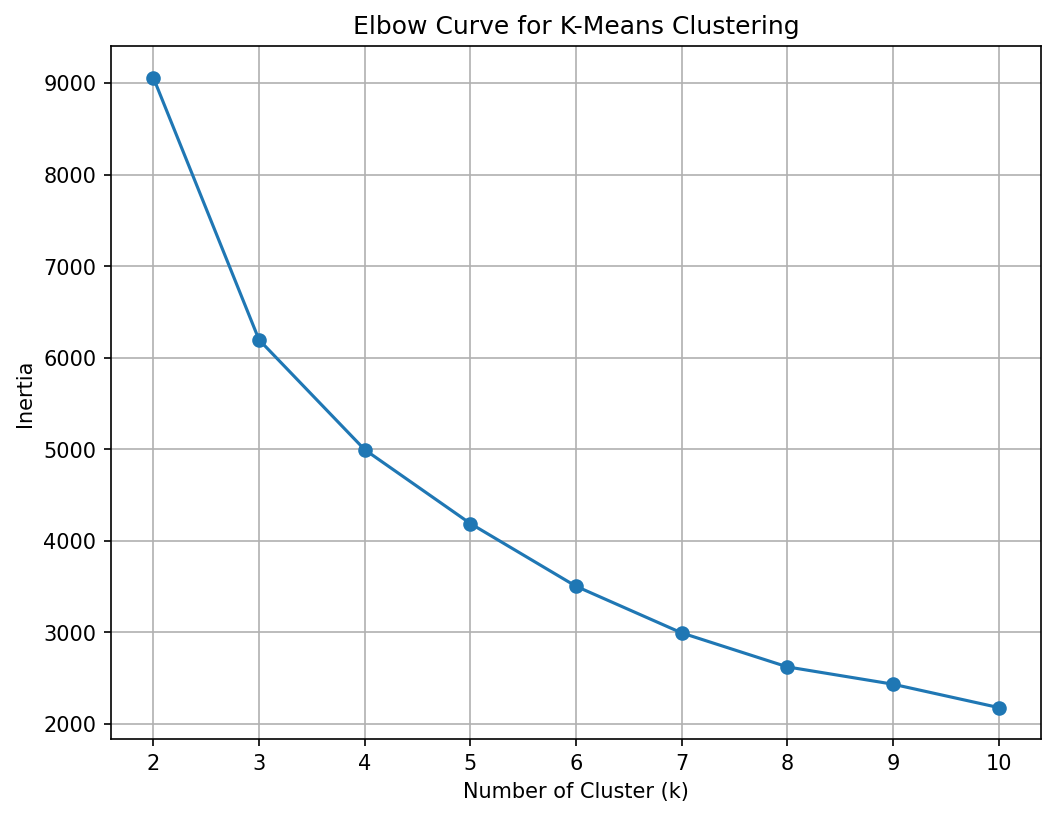

In [53]:
plt.figure(figsize=(8,6),dpi =150)
plt.plot(range(2,11),inertia,marker ='o')
plt.xlabel('Number of Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-Means Clustering')
plt.grid(True)
plt.show()

In [55]:
best_kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
rfm['Cluster'] = best_kmeans.fit_predict(X)

In [56]:
cluster_summary = rfm.groupby('Cluster').agg({
    'R':'mean',
    'F':'mean',
    'M':'mean',
}).reset_index()

In [57]:
print(cluster_summary)

   Cluster         R         F         M
0        0  1.442263  1.061201  1.505774
1        1  3.013043  1.619130  2.820870
2        2  4.550798  3.169086  3.774311
3        3  4.092161  1.103814  1.505297


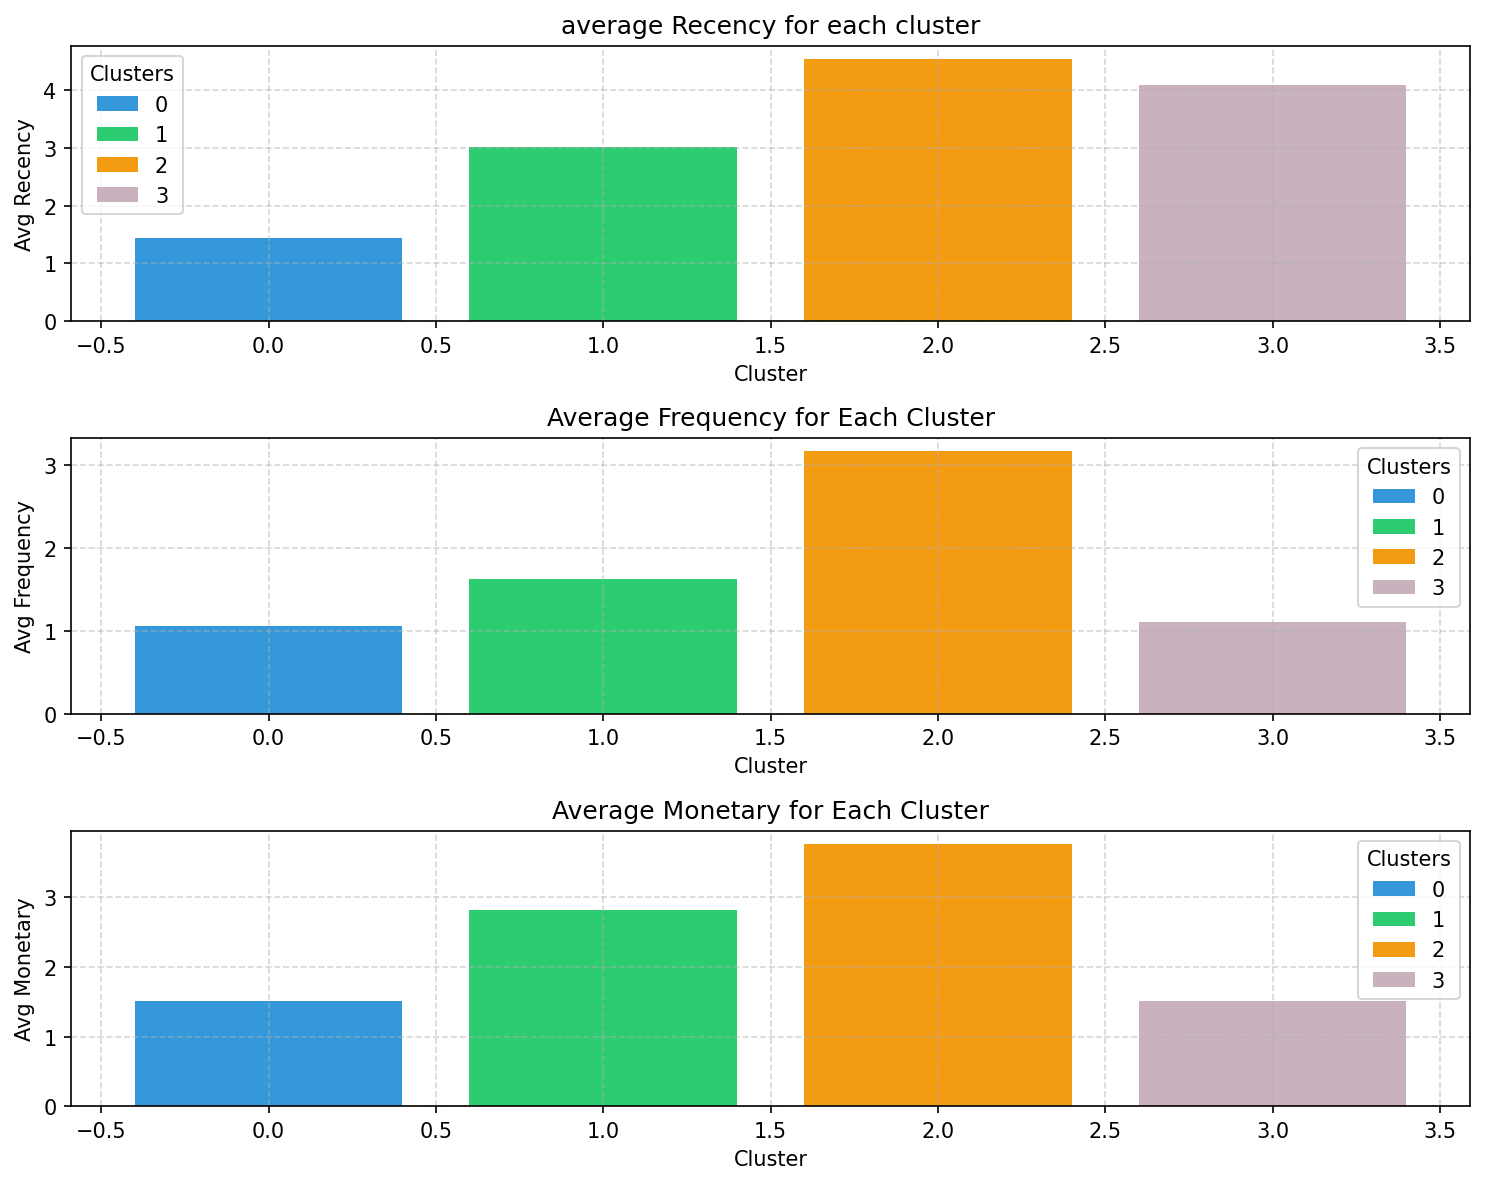

In [66]:
colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']
plt.figure(figsize =(10,8),dpi = 150)

plt.subplot(3,1,1)
bars = plt.bar(cluster_summary.index,cluster_summary['R'],color = colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Recency')
plt.title('average Recency for each cluster')
plt.grid(True, linestyle = '--', alpha=0.5)
plt.legend(bars,cluster_summary.index,title = 'Clusters')

plt.subplot(3, 1, 2)
bars = plt.bar(cluster_summary.index, cluster_summary['F'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Frequency')
plt.title('Average Frequency for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

plt.subplot(3, 1, 3)
bars = plt.bar(cluster_summary.index, cluster_summary['M'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Monetary')
plt.title('Average Monetary for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

plt.tight_layout()
plt.show()


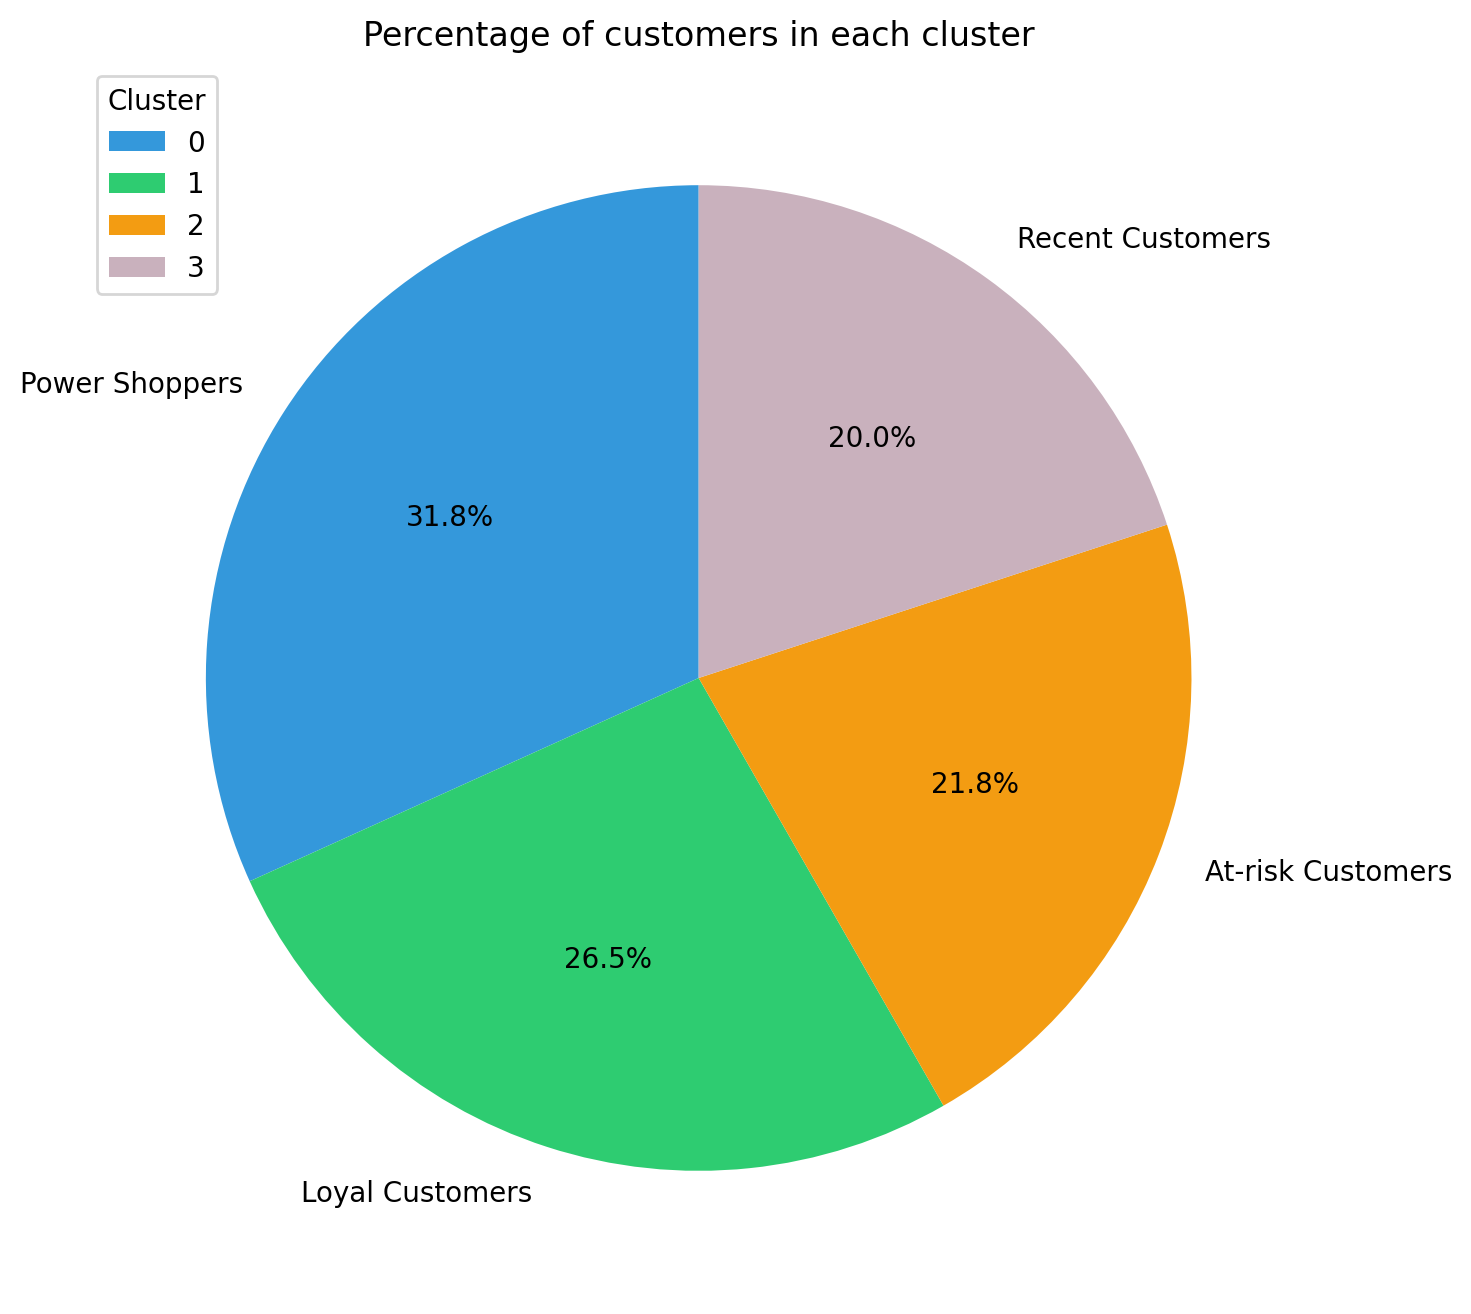

In [65]:
cluster_counts = rfm['Cluster'].value_counts()

colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']
total_customers = cluster_counts.sum()

percentage_customers = (cluster_counts/total_customers)*100
labels = ['Power Shoppers','Loyal Customers','At-risk Customers','Recent Customers']

plt.figure(figsize=(8,8),dpi=200)
plt.pie(percentage_customers,labels=labels,autopct ='%1.1f%%',startangle=90, colors=colors)
plt.title('Percentage of customers in each cluster')
plt.legend(cluster_summary['Cluster'], title='Cluster',loc ='upper left')
plt.show()
